### x lines of Python

# Read SEG-Y with `obspy`

**This notebook goes with [a blog post at Agile*](http://ageo.co/xlines01).**

Before going any further, you might like to know, [What is SEG-Y?](http://www.agilegeoscience.com/blog/2014/3/26/what-is-seg-y.html). See also the articles in [SubSurfWiki](http://www.subsurfwiki.org/wiki/SEG_Y) and [Wikipedia](https://en.wikipedia.org/wiki/SEG_Y).

We'd like to read, alter, and write a SEG-Y file. We'll use the [obspy](https://github.com/obspy/obspy) seismology library to read and write SEG-Y data.
    
Technical SEG-Y documentation:

* [SEG-Y Rev 1](http://seg.org/Portals/0/SEG/News%20and%20Resources/Technical%20Standards/seg_y_rev1.pdf)
* [SEG-Y Rev 2 proposal](https://www.dropbox.com/s/txrqsfuwo59fjea/SEG-Y%20Rev%202.0%20Draft%20August%202015.pdf?dl=0) and [draft repo](http://community.seg.org/web/technical-standards-committee/documents/-/document_library/view/6062543)

<hr />

### A note about running this notebook

If you're running this on mybinder.org, you can ignore all this. It's only for people running this notebook locally.

Hopefully you're already using [Anaconda](https://www.continuum.io/downloads). To make an environment for this notebook, and install `obspy`, you can do this:

    # Make the environment
    conda create -n xlines anaconda Python=3.5
    
    # Start it
    source activate xlines

    # Install obspy and bruges
    conda install obspy
    pip install bruges
    
    # cd to directory with the notebook in it
    jupyter notebook
    
<hr />

### Let's begin!

The 2D seismic line in this post is from the [USGS NPRA Seismic Data Archive](http://energy.usgs.gov/GeochemistryGeophysics/SeismicDataProcessingInterpretation/NPRASeismicDataArchive.aspx), and are in the public domain. This is line number 3X_75_PR.

First, some preliminaries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Tip: you can run a code block by selecting it (click in it), then pressing Shift-Enter. 

## 2D data

ObsPy is really meant for earthquake data, so tends to 'think' in terms of timeseries, as opposed to volumes or 2D lines. It's worth bearing this in mind.

The `headonly=True` option tells ObsPy only to read the header information, but not the traces. This is much faster than reading traces if the file is large. When you access the trace data, ObsPy will go and fetch them from the file.

In [2]:
from obspy.io.segy.segy import _read_segy

stream = _read_segy('../data/3X_75_PR.SGY', headonly=True)

In [3]:
stream

1592 traces in the SEG Y structure.

When we load a 2D line, the stream looks like a list of ObsPy `Trace` objects (even though we didn't actually load the data yet, because of `headonly=True`). We can treat it like any other sequence. For example:

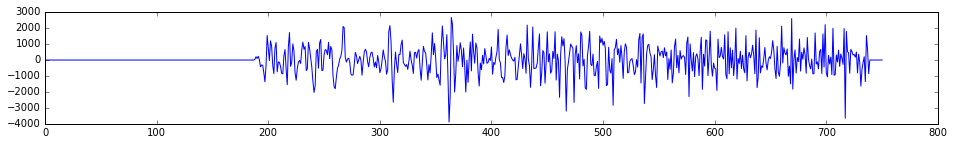

In [4]:
one_trace = stream.traces[0]

plt.figure(figsize=(16,2))
plt.plot(one_trace.data)
plt.show()

We'll get the data from every trace and put it into a NumPy array for ease of manipulation.

The [generator expression](https://docs.python.org/3/reference/expressions.html#generator-expressions) steps over every trace in `stream.traces` and gets its `data`, and then sends the data to `np.stack` which stacks them into an array. 

In [5]:
data = np.stack(t.data for t in stream.traces)

In [6]:
data.shape  # traces, time samples

(1592, 751)

Now we can have a look at what we got using `matplotlib.pyplot.imshow`, a handy way to treat a 2D array as an image. First let's get the 99th percentile of the amplitudes, to help scale the visualization (if we don't we often get what looks like a blank section).

In [7]:
vm = np.percentile(data, 99)
print("The 99th percentile is {:.0f}; the max amplitude is {:.0f}".format(vm, data.max()))

The 99th percentile is 1802; the max amplitude is 1091224


Now we can make the plot. Notice that we have to transpose the array to plot it like this. The reason is that we're storing things with traces in the first dimension ('rows' if you like), for convenience. This way `data[0]` refers to the first trace, not the first time sample. But `imshow` assumes that we're looking at a sort of image, with rows going across the image. 

I'll include this in the *x* lines, because I think it's an important QC step at this point.

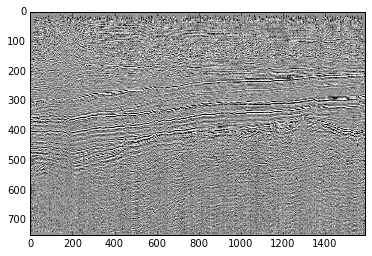

In [8]:
plt.imshow(data.T, cmap="Greys", vmin=-vm, vmax=vm, aspect='auto')

Only 4 lines of Python and we already have a display!

We can make an even nicer plot quite easily.

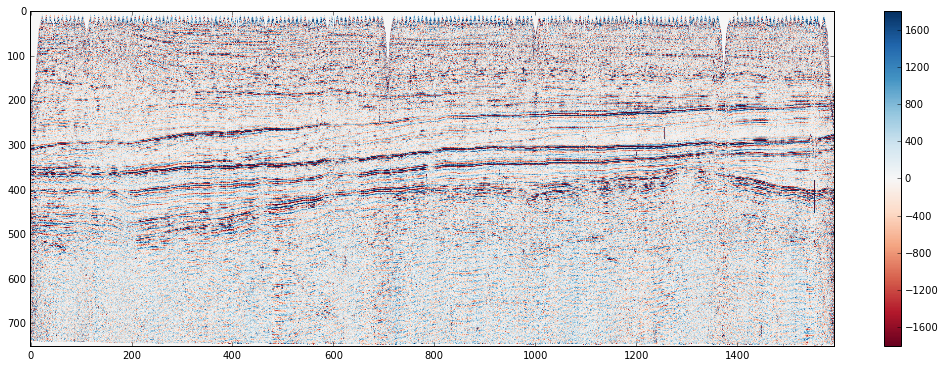

In [9]:
plt.figure(figsize=(18,6))
plt.imshow(data.T, cmap="RdBu", vmin=-vm, vmax=vm, aspect='auto')
plt.colorbar()
plt.show()

## Read the file headers

We can try to read the text header, using `decode` to turn it from bytes into a regular Python string, but it contains no line breaks. 

In [10]:
# If you get nonsense here, the header is probably EBCDIC encoded.
# In that case pass ``encoding='cp037'`` to ``decode``.
print(stream.textual_file_header.decode())

C   CLIENT/JOB ID    0 5 5 5 2 9 3 4 7 2                                        C   LINE  L3X                                                                   C   REEL NO 751023083601   DAY-START OF REEL  23       YEAR 1975                C   INSTRUMENT: MFG TI          MODEL ASC                                       C   DATA TRACES/RECORD0001      AUXILIARY TRACES/RECORD 0       CDP FOLD  0001  C SAMPLE INTERNAL 0000008000 US  SAMPLES/TRACE  0751BITS/IN 1600 BYTES/SAMPLE 4 C   RECORDING FORMAT  STDI              FORMAT THIS REEL SEG Y1                 C   SAMPLE CODE: FLOATING PT                                                    C   GAIN TYPE:   FLOATING PT                                                    C                                                                               C                                                                               C                                                                               C                                       

Usually it's meant to be read with linebreaks, so let's use a bit of a hack to 'reshape' it into 40 lines of 80 characters:

In [11]:
x = np.array(list(stream.textual_file_header.decode()))
print('\n'.join(''.join(row) for row in x.reshape((40, 80))))

C   CLIENT/JOB ID    0 5 5 5 2 9 3 4 7 2                                        
C   LINE  L3X                                                                   
C   REEL NO 751023083601   DAY-START OF REEL  23       YEAR 1975                
C   INSTRUMENT: MFG TI          MODEL ASC                                       
C   DATA TRACES/RECORD0001      AUXILIARY TRACES/RECORD 0       CDP FOLD  0001  
C SAMPLE INTERNAL 0000008000 US  SAMPLES/TRACE  0751BITS/IN 1600 BYTES/SAMPLE 4 
C   RECORDING FORMAT  STDI              FORMAT THIS REEL SEG Y1                 
C   SAMPLE CODE: FLOATING PT                                                    
C   GAIN TYPE:   FLOATING PT                                                    
C                                                                               
C                                                                               
C                                                                               
C                           

Weirdly, the binary file header is easier to read:

In [12]:
print(stream.binary_file_header)

Binary File Header:
	job_identification_number: 1110580000
	line_number: 3
	reel_number: 1110579969
	number_of_data_traces_per_ensemble: 1
	number_of_auxiliary_traces_per_ensemble: 0
	sample_interval_in_microseconds: 8000
	sample_interval_in_microseconds_of_original_field_recording: 0
	number_of_samples_per_data_trace: 751
	number_of_samples_per_data_trace_for_original_field_recording: 0
	data_sample_format_code: 1
	ensemble_fold: 1
	trace_sorting_code: 4
	vertical_sum_code: 1
	sweep_frequency_at_start: 0
	sweep_frequency_at_end: 0
	sweep_length: 0
	sweep_type_code: 0
	trace_number_of_sweep_channel: 0
	sweep_trace_taper_length_in_ms_at_start: 0
	sweep_trace_taper_length_in_ms_at_end: 0
	taper_type: 0
	correlated_data_traces: 0
	binary_gain_recovered: 1
	amplitude_recovery_method: 4
	measurement_system: 0
	impulse_signal_polarity: 0
	vibratory_polarity_code: 0
	unassigned_1: b'\xff\xfe\x00\x0c\x00\x01\x00\x00\x17p\x00\x01\x00\x01\x00\x08\x0c\x80\x00\x80\x00\x00\x00\x9b\x00\x02\x00\x9f\x

## Look at traces

Since we're looking at headers, let's look at the header of the first trace:

In [13]:
print(stream.traces[0].header)

trace_sequence_number_within_line: 1
trace_sequence_number_within_segy_file: 1
original_field_record_number: 11
trace_number_within_the_original_field_record: 0
energy_source_point_number: 0
ensemble_number: 1
trace_number_within_the_ensemble: 1
trace_identification_code: 1
number_of_vertically_summed_traces_yielding_this_trace: 1
number_of_horizontally_stacked_traces_yielding_this_trace: 1
data_use: 1
distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group: 0
receiver_group_elevation: 0
surface_elevation_at_source: 0
source_depth_below_surface: 0
datum_elevation_at_receiver_group: 0
datum_elevation_at_source: 0
water_depth_at_source: 0
water_depth_at_group: 0
scalar_to_be_applied_to_all_elevations_and_depths: 0
scalar_to_be_applied_to_all_coordinates: 1
source_coordinate_x: 0
source_coordinate_y: 0
group_coordinate_x: 0
group_coordinate_y: 0
coordinate_units: 0
weathering_velocity: 0
subweathering_velocity: 0
uphole_time_at_source_in_ms: 0
uphole_time_at_group_in_

Check what various fields look like:

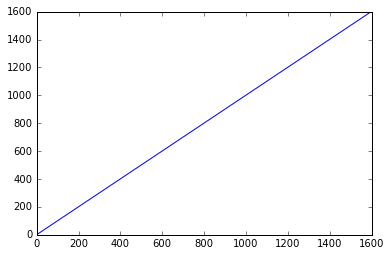

In [14]:
plt.plot([t.header.trace_sequence_number_within_segy_file for t in stream.traces])
plt.show()

## Write data

In [15]:
from obspy.core import AttribDict
from obspy.core import Stats

from obspy.core import Trace, Stream
from obspy.io.segy.segy import SEGYBinaryFileHeader
from obspy.io.segy.segy import SEGYTraceHeader

Let's make a change to the trace data, and save it as a new SEG-Y file.

In [16]:
import bruges

In [17]:
dt = stream.traces[0].header.sample_interval_in_ms_for_this_trace / 1e6
similarity = bruges.attribute.similarity(data, duration=0.16, dt=dt)

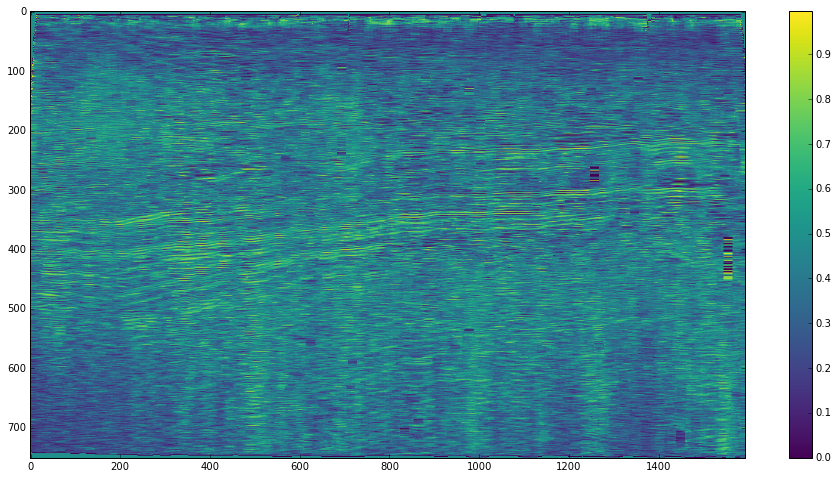

In [18]:
plt.figure(figsize=(16,8))
plt.imshow(similarity.T, cmap="viridis", aspect='auto')
plt.colorbar()
plt.show()

Now we have something worth writing (OK, maybe not, this section is pretty boring, but whatever, you get the idea). We make a new `Stream` object from a sequence of `Trace` objects, putting their sample intervals in the headers &mdash; a requirement of ObsPy.

This might seem really terse, but I'm on a budget :) It's basically the same as this long-hand, annotated Python, using `t` for 'a trace-like 1D array from my NumPy array' and `trace` for 'an ObsPy `Trace` object:

    out = Stream()                      # Make a new Stream object, basically an empty list-like thing.
    for t in similarity:                # Loop over all trace-like things in the similarity array.
        header = {'delta': dt}          # Make a header for the trace; ObsPy needs this.
        trace = Trace(t, header=header) # Make the ObsPy Trace with the data and the header.
        out.append(trace)               # Append the Trace to the Stream.
        
This short-hand form is called a generator expression, one of the most useful bits of Python there is. It does exactly the same thing.

In [19]:
out = Stream(Trace(t, header=dict(delta=dt)) for t in similarity)

We should add some info to the header, which can contain up to 40 lines of 80 characters. We'll start by recycling the first ten lines of the existing header:

In [20]:
out.stats = Stats(dict(textual_file_header=stream.textual_file_header[:800]))

Now we can add to it:

In [21]:
out.stats.textual_file_header += """Similarity volume.
Generated: 18 Sep 2016 by Matt Hall matt@agilegeoscience.com.
Algorithm: github.com/agile-geoscience/bruges.attribute.similarity.
Parameters: duration=0.16 s, dt=0.008 s.""".encode('utf-8')

And then write the file (there's a warning about ObsPy having to create the trace headers. We could have done this, but I'm on a budget!)

In [22]:
out.write('out.sgy', format='SEGY', data_encoding=5)  # encode 1 for IBM, 5 for IEEE

/home/matt/anaconda/envs/xlines/lib/python3.5/site-packages/obspy/io/segy/core.py:398: UserWarning: CREATING TRACE HEADER
  warnings.warn("CREATING TRACE HEADER")


## Validate what we did

I figured you might not believe that this did what we wanted... so let's check the header of the file we just created.

In [23]:
s = _read_segy('out.sgy', headonly=True)

In [24]:
s.textual_file_header[:15*80]  # First 15 lines.

b'C   CLIENT/JOB ID    0 5 5 5 2 9 3 4 7 2                                        C   LINE  L3X                                                                   C   REEL NO 751023083601   DAY-START OF REEL  23       YEAR 1975                C   INSTRUMENT: MFG TI          MODEL ASC                                       C   DATA TRACES/RECORD0001      AUXILIARY TRACES/RECORD 0       CDP FOLD  0001  C SAMPLE INTERNAL 0000008000 US  SAMPLES/TRACE  0751BITS/IN 1600 BYTES/SAMPLE 4 C   RECORDING FORMAT  STDI              FORMAT THIS REEL SEG Y1                 C   SAMPLE CODE: FLOATING PT                                                    C   GAIN TYPE:   FLOATING PT                                                    C                                                                               Similarity volume.\nGenerated: 18 Sep 2016 by Matt Hall matt@agilegeoscience.com.\nAlgorithm: github.com/agile-geoscience/bruges.attribute.similarity.\nParameters: duration=0.16 s, dt=0.008 s.      

And the actual trace data:

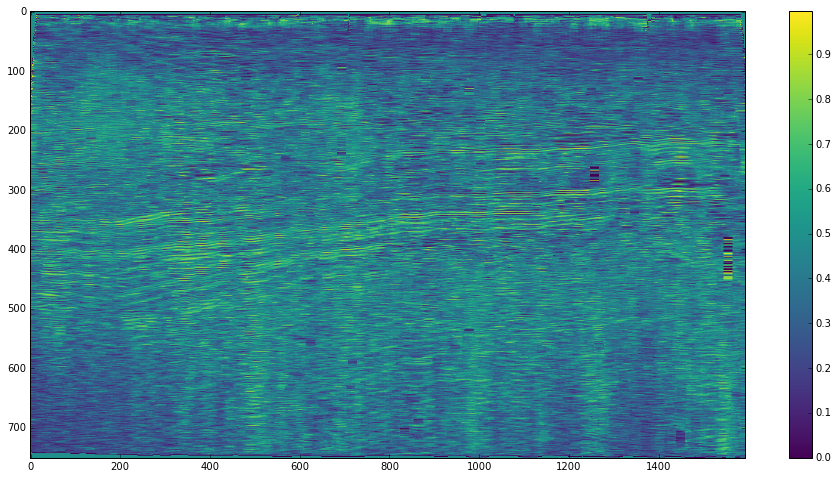

In [25]:
plt.figure(figsize=(16,8))
plt.imshow(np.vstack(t.data for t in s.traces).T,
           cmap='viridis',
           aspect='auto')
plt.colorbar()
plt.show()

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2016</p>
</div>